In [105]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline  

import seaborn as sns 

import statsmodels.api as sm
import statsmodels.formula.api as smf


import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import scipy.stats as stats

import math 

In [5]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [6]:
# Scrub - Converting data types 

In [7]:
#convert column name ['date'] from object to datetime 

#might be cool to create a function that takes any column date and converts it 

df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

In [8]:
# Obvious issue with sqft_basement due to columns
#First attempt to convert failed due to ? marks so we need to remove them 

df['sqft_basement'].nunique() 

304

In [9]:
#replacing all ? with 0's - major assumption that requires data enrichment to correct
#

df['sqft_basement'] = df['sqft_basement'].map(lambda x: 0 if x==
                                             '?' else x)

df['sqft_basement'] = df['sqft_basement'].astype(float)

In [10]:
# Scrub - Treating Null values 

In [11]:
# Identify null values 

df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [12]:
# Look for columns where all 3 are missing 
#This isnt a huge % of the data so we allow it 

print('Number Missing All Three:',
     len(df[(df.waterfront.isnull())
           & (df.view.isnull())
           & (df.yr_renovated.isnull())]))

Number Missing All Three: 2


In [13]:
#Repeat the same process for view which indicates how many times a house has been viewed

#We replaced all views with a median value, its safe to assume houses on the market in these areas are quite popular and viewed 
median = df['view'].median()
df['view'] = df['view'].fillna(value=median)#Waterfront 0 = No waterfront, 1=Waterfront 

#Making all nulls 0 indicating no waterfront 

df['waterfront'].isna().sum()

df['waterfront'] = df['waterfront'].fillna(0)

In [14]:
# Assuming renovation nulls are the same as renovation yr_built 

df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [15]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# Major assumptions of scrubbing 

1. Waterfront - nulls = 0 and 1 means on the waterfront, replaced all nulls with 0 

2. Filled view with median value, assuming all houses are viewed or in demand (justification is this is a major area with lots of people moving there) 

3. if there is no yr_renovated, fill with most recent year built 

In [16]:
#dropped all duplicates for id 
#inplace = True changes the dataframe permanently

df.drop_duplicates(subset=['id'], inplace=True)

# Scrubbing - Outliers 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000172BF14D7B8>,
      dtype=object)

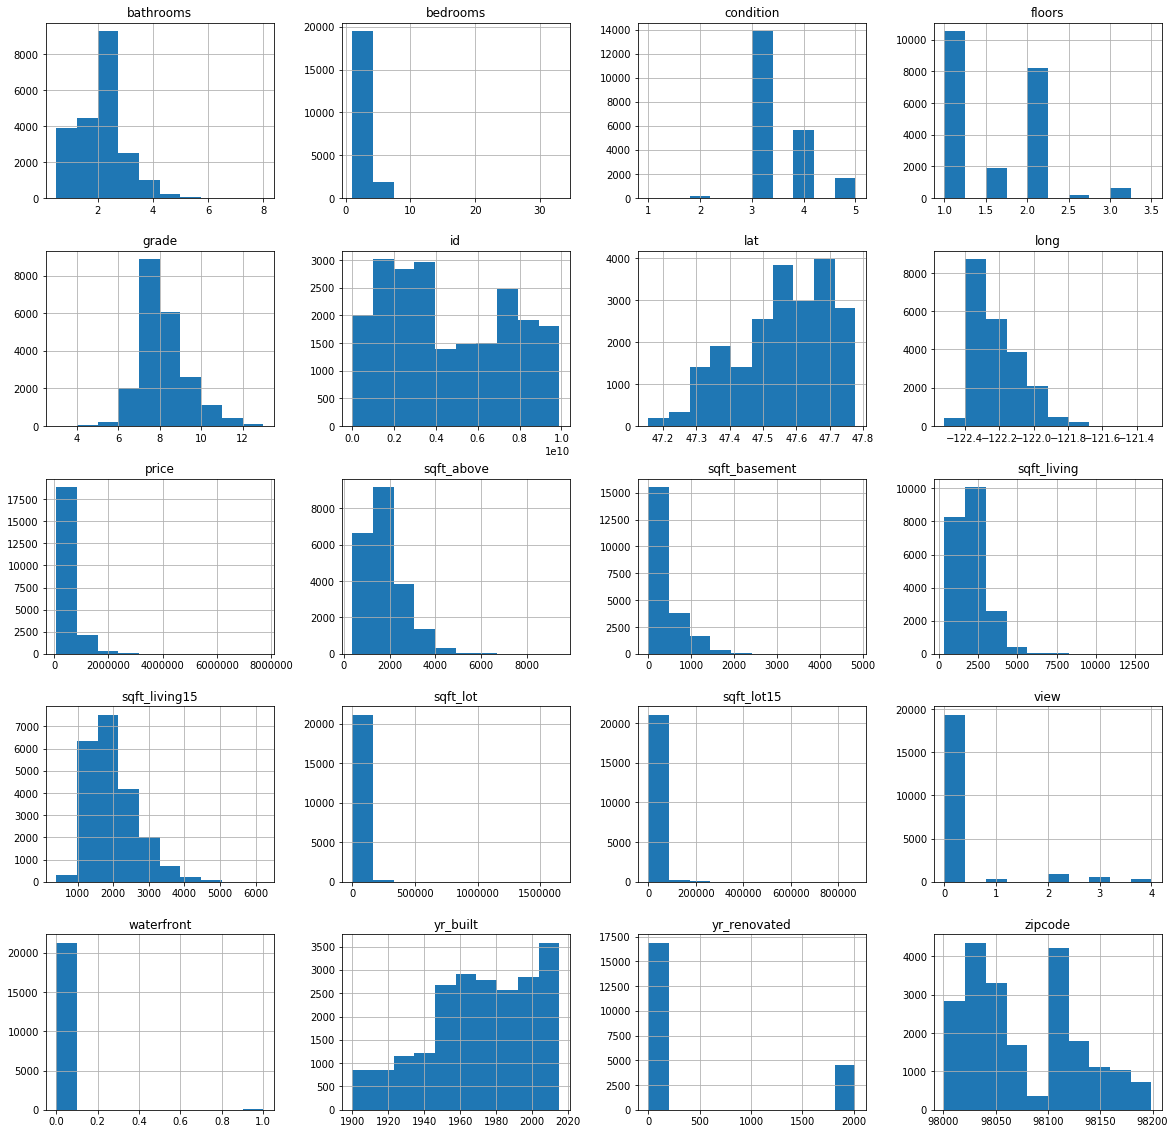

In [17]:
df.hist(figsize=(20,20))

# Exploring Categorical & Numerical Variables 

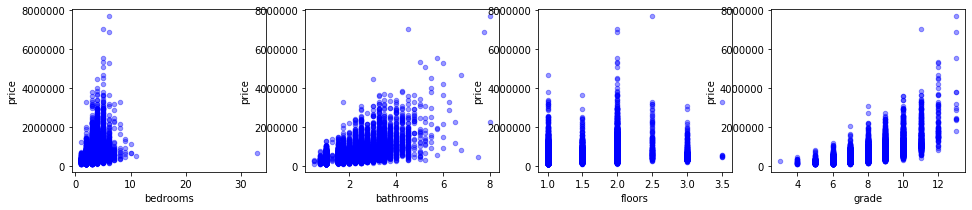

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'floors', 'grade'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

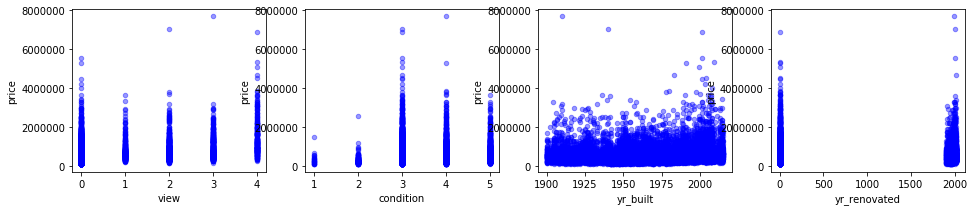

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['view', 'condition', 'yr_built', 'yr_renovated'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

# Checking for Linear Relationships to find the best data
## Comment/uncomment cell below for outlier removal code 

In [17]:
#sqft_living 

indexNames = df[df['sqft_living'] >= 5000 ].index
df.drop(indexNames , inplace=True)

# sqft_above 

indexNames = df[df['sqft_above'] >= 4500 ].index
df.drop(indexNames , inplace=True)

#sqft_basement 

indexNames = df[df['sqft_basement'] >= 2000 ].index
df.drop(indexNames , inplace=True)

# dropping sqft_lot outliers

indexNames = df[df['sqft_lot'] >= 100000 ].index
df.drop(indexNames , inplace=True)

# dropping sqft_living15 outliers

indexNames = df[df['sqft_living15'] >= 4500 ].index
df.drop(indexNames , inplace=True)


# dropping sqft_lot15 outliers

indexNames = df[df['sqft_lot15'] >= 100000 ].index
df.drop(indexNames , inplace=True)


# dropping grade outliers
indexNames = df[df['grade'] == 3 ].index
df.drop(indexNames , inplace=True)

indexNames = df[df['grade'] == 13 ].index
df.drop(indexNames , inplace=True)

# dropping bedroom outliers over 8 rooms
indexNames = df[df['bedrooms'] >= 8 ].index
df.drop(indexNames , inplace=True)

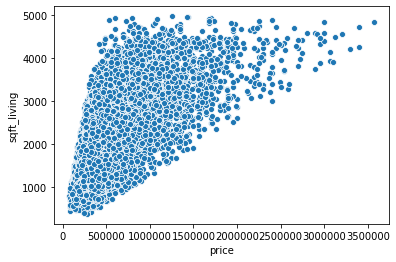

In [18]:
sns.scatterplot(x='price', y='sqft_living', data=df)

(array([ 576., 3342., 4967., 4445., 3178., 1956., 1163.,  579.,  291.,
          71.]),
 array([ 370.,  831., 1292., 1753., 2214., 2675., 3136., 3597., 4058.,
        4519., 4980.]),
 <a list of 10 Patch objects>)

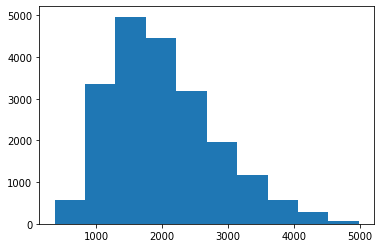

In [19]:
# Histogram of variable 

plt.hist(df['sqft_living'])

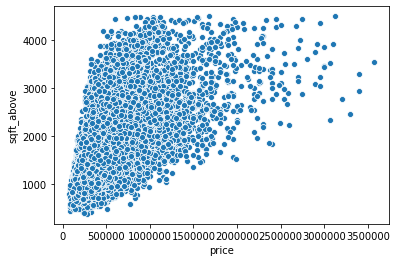

In [20]:
sns.scatterplot(x='price', y='sqft_above', data=df)

(array([ 624., 4669., 5743., 3548., 2268., 1708., 1045.,  565.,  272.,
         126.]),
 array([ 370.,  782., 1194., 1606., 2018., 2430., 2842., 3254., 3666.,
        4078., 4490.]),
 <a list of 10 Patch objects>)

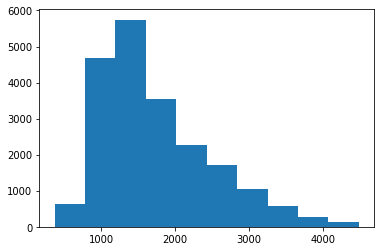

In [21]:
plt.hist(df['sqft_above'])

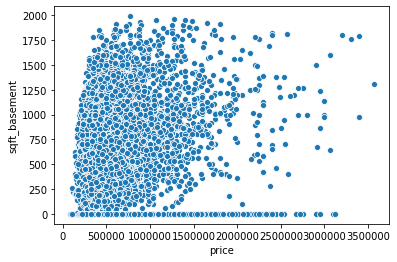

In [22]:
sns.scatterplot(x='price', y='sqft_basement', data=df)

(array([13111.,  1164.,  1558.,  1602.,  1413.,   875.,   480.,   226.,
           93.,    46.]),
 array([   0.,  199.,  398.,  597.,  796.,  995., 1194., 1393., 1592.,
        1791., 1990.]),
 <a list of 10 Patch objects>)

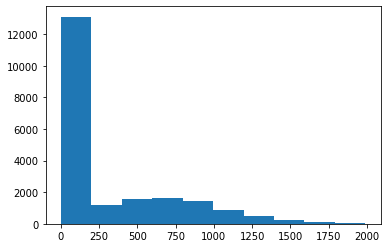

In [23]:
plt.hist(df['sqft_basement'])

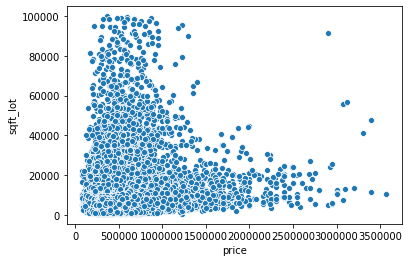

In [24]:
sns.scatterplot(x='price', y='sqft_lot', data=df)

(array([15796.,  3180.,   525.,   443.,   287.,   137.,    73.,    50.,
           39.,    38.]),
 array([  520. , 10459.6, 20399.2, 30338.8, 40278.4, 50218. , 60157.6,
        70097.2, 80036.8, 89976.4, 99916. ]),
 <a list of 10 Patch objects>)

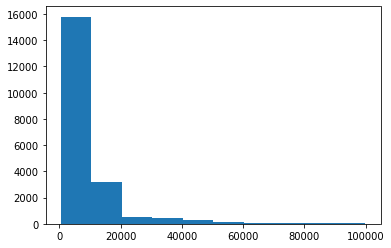

In [25]:
plt.hist(df['sqft_lot'])

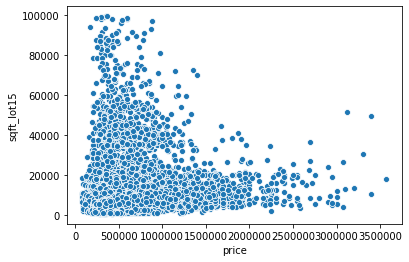

In [26]:
sns.scatterplot(x='price', y='sqft_lot15', data=df)

(array([16528.,  2767.,   383.,   437.,   222.,   109.,    45.,    29.,
           26.,    22.]),
 array([  651. , 10517.5, 20384. , 30250.5, 40117. , 49983.5, 59850. ,
        69716.5, 79583. , 89449.5, 99316. ]),
 <a list of 10 Patch objects>)

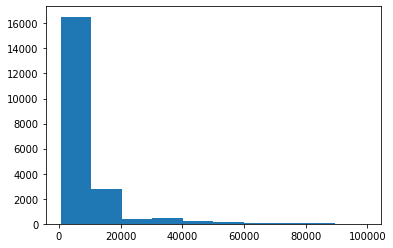

In [27]:
plt.hist(df['sqft_lot15'])

# Clearly need to remove outliers and perform a log function
## Comment cell to remove outliers 

# Performing Log Functions on numerical_df

In [28]:
df_num = df[['price', 'bedrooms', 'bathrooms','floors', 'sqft_living', 'sqft_lot', 'sqft_above','sqft_basement','sqft_living15', 'sqft_lot15']].copy()

ValueError: supplied range of [-inf, 8.480529207044645] is not finite

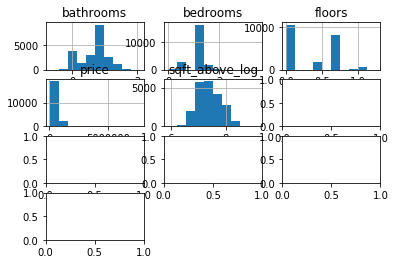

In [152]:
df_num.hist()

In [29]:
#created a logged numerical df 

df_sqft_logs = pd.DataFrame([])
df_sqft_logs = df_num

In [30]:
df_sqft_logs['sqft_living_log'] = np.log(df_sqft_logs['sqft_living'])
df_sqft_logs['sqft_above_log'] = np.log(df_sqft_logs['sqft_above'])
df_sqft_logs['sqft_lot_log'] = np.log(df_sqft_logs['sqft_lot'])
df_sqft_logs['sqft_basement_log'] = np.log(df_sqft_logs['sqft_basement'])
df_sqft_logs['sqft_living15_log'] = np.log(df_sqft_logs['sqft_living15'])
df_sqft_logs['sqft_lot15_log'] = np.log(df_sqft_logs['sqft_lot15'])
df_sqft_logs['bathrooms'] = np.log(df_sqft_logs['bathrooms'])
df_sqft_logs['bedrooms'] = np.log(df_sqft_logs['bedrooms'])
df_sqft_logs['floors'] = np.log(df_sqft_logs['floors'])

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
# Data is now evenly distributed, lets check for linearity 

In [32]:
headers = list(df_sqft_logs)

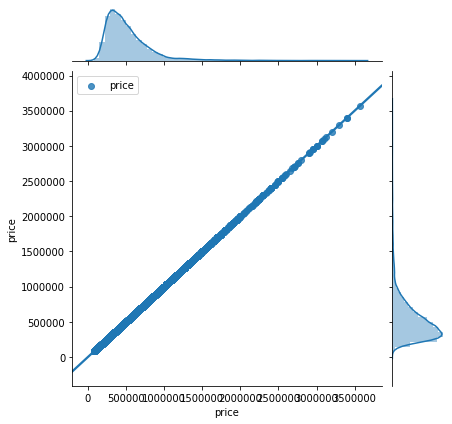

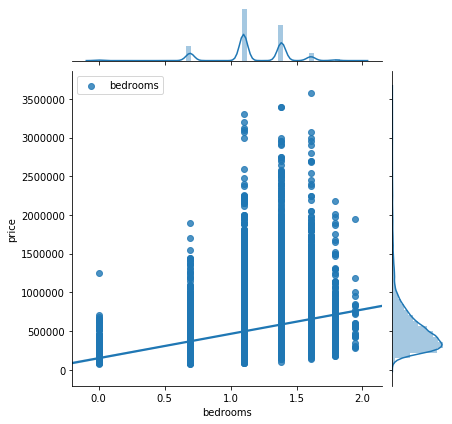

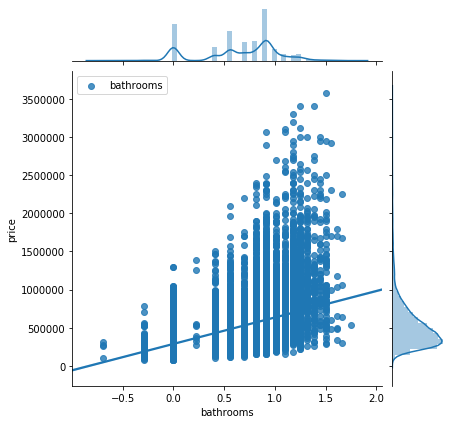

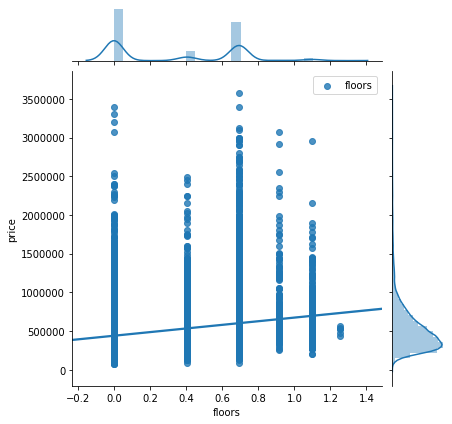

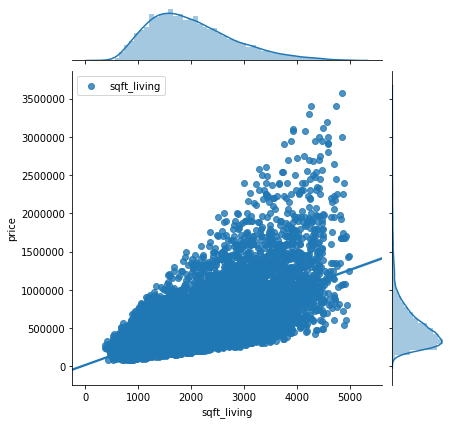

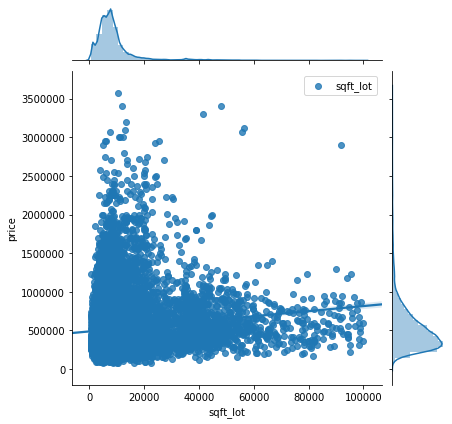

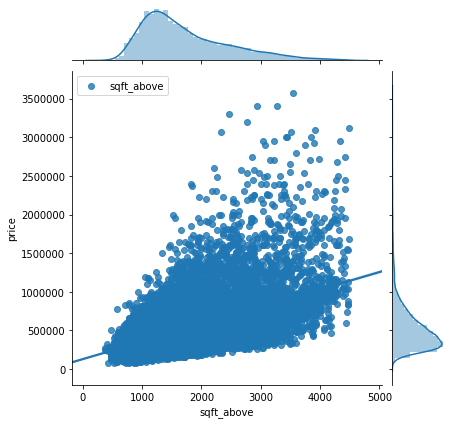

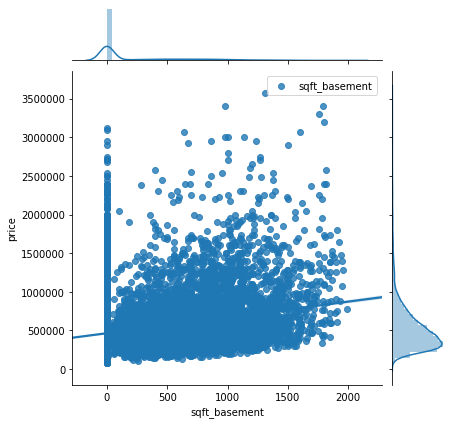

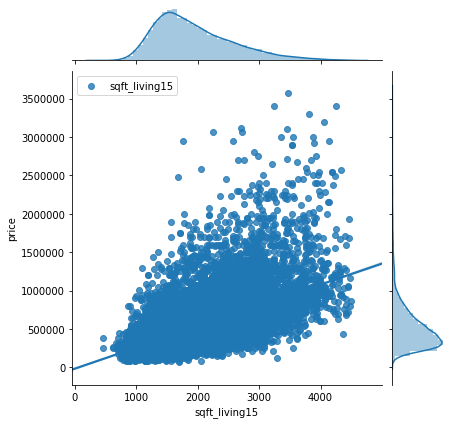

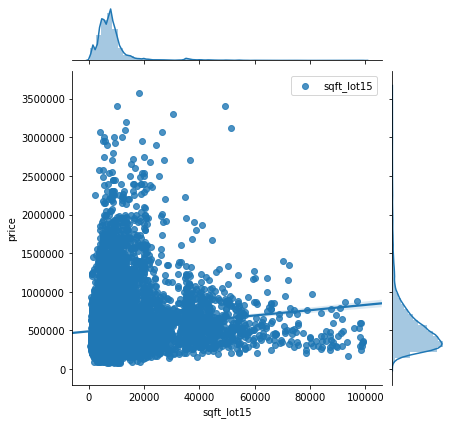

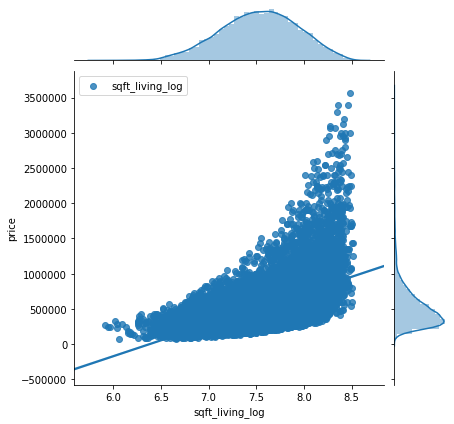

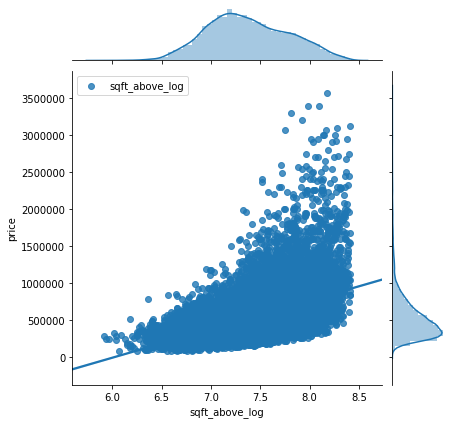

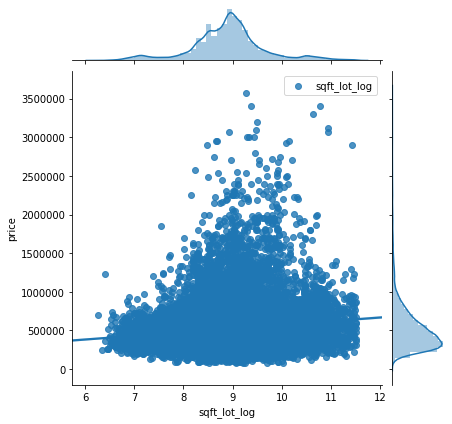

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:39: RuntimeWarning: invalid value encountered in double_scalars
  return int(np.ceil((a.max() - a.min()) / h))


ValueError: cannot convert float NaN to integer

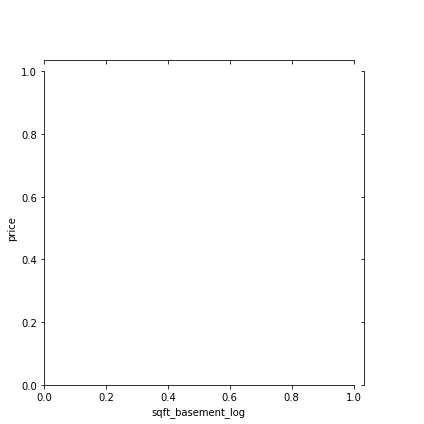

In [33]:
for column in headers:
    sns.jointplot(x=column, y='price',
                 data=df_sqft_logs,
                 kind='reg',
                 label=column,
                 )
    plt.legend()
    plt.show()

# Encoding Categorical Variables

In [34]:
df_cat = df[['view', 'condition', 'waterfront','grade', 'yr_built', 'yr_renovated']].copy()

In [35]:
df_cat['condition'] = df_cat['condition'].astype("int")
df_cat['waterfront'] =  df_cat['waterfront'].astype("int")

In [36]:
df_cat.columns = df_cat.columns.astype("str")

In [37]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20568 entries, 0 to 21596
Data columns (total 6 columns):
view            20568 non-null float64
condition       20568 non-null int32
waterfront      20568 non-null int32
grade           20568 non-null int64
yr_built        20568 non-null int64
yr_renovated    20568 non-null float64
dtypes: float64(2), int32(2), int64(2)
memory usage: 964.1 KB


In [38]:
df_cat = pd.get_dummies(df_cat, drop_first=True) #pd
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20568 entries, 0 to 21596
Data columns (total 6 columns):
view            20568 non-null float64
condition       20568 non-null int32
waterfront      20568 non-null int32
grade           20568 non-null int64
yr_built        20568 non-null int64
yr_renovated    20568 non-null float64
dtypes: float64(2), int32(2), int64(2)
memory usage: 964.1 KB


# Combine categorical and numerical data

In [39]:
df_combo = pd.concat([df_sqft_logs, df_cat], axis=1)
df_combo.head()  

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,...,sqft_lot_log,sqft_basement_log,sqft_living15_log,sqft_lot15_log,view,condition,waterfront,grade,yr_built,yr_renovated
0,221900.0,1.098612,0.000000,0.000000,1180,5650,1180,0.0,1340,5650,...,8.639411,-inf,7.200425,8.639411,0.0,3,0,7,1955,0.0
1,538000.0,1.098612,0.810930,0.693147,2570,7242,2170,400.0,1690,7639,...,8.887653,5.991465,7.432484,8.941022,0.0,3,0,7,1951,1991.0
2,180000.0,0.693147,0.000000,0.000000,770,10000,770,0.0,2720,8062,...,9.210340,-inf,7.908387,8.994917,0.0,3,0,6,1933,1933.0
3,604000.0,1.386294,1.098612,0.000000,1960,5000,1050,910.0,1360,5000,...,8.517193,6.813445,7.215240,8.517193,0.0,5,0,7,1965,0.0
4,510000.0,1.098612,0.693147,0.000000,1680,8080,1680,0.0,1800,7503,...,8.997147,-inf,7.495542,8.923058,0.0,3,0,8,1987,0.0


In [40]:
for cat_names in df_combo.iloc[:,11:].columns:
    df_combo[cat_names] = df_combo[cat_names].astype('category')

In [41]:
# OLS Regression

In [42]:
# OLS Regression

#It didnt seem to work!

import statsmodels.api as sm
import statsmodels.formula.api as smf

col_names = df_combo.describe().columns[1:11] #What does this?

results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p_value ']] #creating an array of results we care about

for idx, val in enumerate(col_names):
    print('price~' + val)
    f = 'price~' + val
    model = smf.ols(formula=f, data=df_combo).fit()
    X_new = pd.DataFrame({val: [df_combo[val].min(), df_combo[val].max()]});
    preds = model.predict(X_new)
    results.append({val, model.rsquared, model.params[0], model.params[1], model.pvalues[1]})

    print(results[idx+1])
    print(model.summary())

price~bedrooms
{0.08169228554504182, 0.0, 314627.2065113989, 'bedrooms', 149692.460885135}
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     1830.
Date:                Thu, 13 Feb 2020   Prob (F-statistic):               0.00
Time:                        01:28:23   Log-Likelihood:            -2.8818e+05
No. Observations:               20568   AIC:                         5.764e+05
Df Residuals:                   20566   BIC:                         5.764e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

{0.29640611245076065, 225.24817507531182, 0.0, 'sqft_above', 127532.3783001614}
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     8664.
Date:                Thu, 13 Feb 2020   Prob (F-statistic):               0.00
Time:                        01:28:24   Log-Likelihood:            -2.8544e+05
No. Observations:               20568   AIC:                         5.709e+05
Df Residuals:                   20566   BIC:                         5.709e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [45]:
df_num.corr()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_basement_log,sqft_living15_log,sqft_lot15_log
price,1.000000,0.285819,0.434301,0.268896,0.649537,0.114020,0.544432,0.275985,0.571458,0.103520,0.593556,0.515154,0.117244,0.270311,0.541229,0.109716
bedrooms,0.285819,1.000000,0.523089,0.204071,0.598574,0.112931,0.495838,0.261215,0.403380,0.105641,0.650176,0.544592,0.227758,0.442750,0.422781,0.205498
bathrooms,0.434301,0.523089,1.000000,0.508275,0.706456,0.073162,0.626925,0.236643,0.534279,0.073177,0.746485,0.665089,0.034520,0.334547,0.554281,0.034638
floors,0.268896,0.204071,0.508275,1.000000,0.380924,-0.092294,0.569117,-0.277605,0.296752,-0.086923,0.384446,0.578616,-0.289614,-0.215417,0.290771,-0.274252
sqft_living,0.649537,0.598574,0.706456,0.380924,1.000000,0.242852,0.856707,0.389845,0.752808,0.227849,0.969870,0.843478,0.314090,0.629120,0.738669,0.292472
sqft_lot,0.114020,0.112931,0.073162,-0.092294,0.242852,1.000000,0.232490,0.053026,0.286167,0.834525,0.227070,0.223003,0.814608,0.221631,0.278830,0.730953
sqft_above,0.544432,0.495838,0.626925,0.569117,0.856707,0.232490,1.000000,-0.132284,0.722420,0.225621,0.822293,0.972299,0.284036,0.250997,0.698744,0.269079
sqft_basement,0.275985,0.261215,0.236643,-0.277605,0.389845,0.053026,-0.132284,1.000000,0.159216,0.036211,0.393477,-0.108529,0.097179,0.927701,0.173710,0.082637
sqft_living15,0.571458,0.403380,0.534279,0.296752,0.752808,0.286167,0.722420,0.159216,1.000000,0.293318,0.726035,0.703390,0.360681,0.374124,0.980561,0.370726
sqft_lot15,0.103520,0.105641,0.073177,-0.086923,0.227849,0.834525,0.225621,0.036211,0.293318,1.000000,0.212985,0.215507,0.729596,0.224011,0.284551,0.820391


In [46]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [47]:
# Non encoded, assumptions of regression not met in regression below 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15']

In [48]:
# Some brief preprocessing
df.columns = [col.replace(' ', '_') for col in df.columns]
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,-0.399924,-1.492128,-1.044272,-0.405855,-0.905984,-0.076283,-0.292136,...,-0.550966,-0.749355,-0.662603,-0.530155,-0.520003,98178,47.5112,-122.257,-0.954664,-0.399311
1,6414100192,2014-12-09,538000.0,-0.399924,0.229616,0.691343,-0.256570,0.944490,-0.076283,-0.292136,...,-0.550966,0.584910,0.303026,-0.665889,1.943098,98125,47.7210,-122.319,-0.408446,-0.184876
2,5631500400,2015-02-25,180000.0,-1.543007,-1.492128,-1.556217,0.002051,-0.905984,-0.076283,-0.292136,...,-1.462066,-1.301929,-0.662603,-1.276692,1.871345,98028,47.7379,-122.233,1.198997,-0.139272
3,2487200875,2014-12-09,604000.0,0.743160,1.262663,-0.070330,-0.466806,-0.905984,-0.076283,-0.292136,...,-0.550966,-0.924561,1.534203,-0.190820,-0.520003,98136,47.5208,-122.393,-0.923452,-0.469388
4,1954400510,2015-02-18,510000.0,-0.399924,-0.114733,-0.419950,-0.177990,-0.905984,-0.076283,-0.292136,...,0.360134,-0.075484,-0.662603,0.555717,-0.520003,98074,47.6168,-122.045,-0.236777,-0.199538


In [49]:
from statsmodels.formula.api import ols

In [50]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     2345.
Date:                Thu, 13 Feb 2020   Prob (F-statistic):               0.00
Time:                        01:28:35   Log-Likelihood:            -2.7879e+05
No. Observations:               20568   AIC:                         5.576e+05
Df Residuals:                   20552   BIC:                         5.577e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.186e+05   1300.411    398.770      0.000    5.16e+05    5.21e+05
bedrooms      -2.694e+04   1707.630    -15.774      0.000   -3.03e+04   -2.36e+04
bathrooms      2.919e+04   2289.422     12.748      0.000    2.47e+04    3.37e+04
sqft_living    6.846e+04   1.45e+04      4.727      0.000    4.01e+04    9.68e+04
sqft_lot      -5556.3474   2386.568     -2.328      0.020   -1.02e+04    -878.485
floors         1.991e+04   1865.803     10.671      0.000    1.63e+04    2.36e+04
waterfront     3.731e+04   1413.002     26.404      0.000    3.45e+04    4.01e+04
view           3.295e+04   1512.059     21.793      0.000       3e+04    3.59e+04
condition      1.547e+04   1427.127     10.842      0.000    1.27e+04    1.83e+04
grade          1.334e+05   2225.200     59.931      0.000    1.29e+05    1.38e+05
sqft_above      1.94e+04   1.34e+04      1.452      0.147   -6796.510    4.56e+04
sqft_basement   1.82e+04   7404.577      2.458      0.014    3689.067    3.27e+04
yr_built      -1.004e+05   1777.829    -56.466      0.000   -1.04e+05   -9.69e+04
yr_renovated   3383.7988   1314.360      2.574      0.010     807.548    5960.049
sqft_living15  3.242e+04   2198.376     14.745      0.000    2.81e+04    3.67e+04
sqft_lot15    -1.376e+04   2389.001     -5.759      0.000   -1.84e+04   -9076.445
==============================================================================
Omnibus:                     8857.236   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101835.423
Skew:                           1.757   Prob(JB):                         0.00
Kurtosis:                      13.319   Cond. No.                         35.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# Same as above but removed 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15']

cols_removed = ['sqft_above', 'sqft_living15', 'waterfront']

In [52]:
# Some brief preprocessing
df.columns = [col.replace(' ', '_') for col in df.columns]
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,-0.399924,-1.492128,-1.044272,-0.405855,-0.905984,-0.076283,-0.292136,...,-0.550966,-0.749355,-0.662603,-0.530155,-0.520003,98178,47.5112,-122.257,-0.954664,-0.399311
1,6414100192,2014-12-09,538000.0,-0.399924,0.229616,0.691343,-0.256570,0.944490,-0.076283,-0.292136,...,-0.550966,0.584910,0.303026,-0.665889,1.943098,98125,47.7210,-122.319,-0.408446,-0.184876
2,5631500400,2015-02-25,180000.0,-1.543007,-1.492128,-1.556217,0.002051,-0.905984,-0.076283,-0.292136,...,-1.462066,-1.301929,-0.662603,-1.276692,1.871345,98028,47.7379,-122.233,1.198997,-0.139272
3,2487200875,2014-12-09,604000.0,0.743160,1.262663,-0.070330,-0.466806,-0.905984,-0.076283,-0.292136,...,-0.550966,-0.924561,1.534203,-0.190820,-0.520003,98136,47.5208,-122.393,-0.923452,-0.469388
4,1954400510,2015-02-18,510000.0,-0.399924,-0.114733,-0.419950,-0.177990,-0.905984,-0.076283,-0.292136,...,0.360134,-0.075484,-0.662603,0.555717,-0.520003,98074,47.6168,-122.045,-0.236777,-0.199538


In [53]:
from statsmodels.formula.api import ols

In [54]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     2565.
Date:                Thu, 13 Feb 2020   Prob (F-statistic):               0.00
Time:                        01:28:40   Log-Likelihood:            -2.7914e+05
No. Observations:               20568   AIC:                         5.583e+05
Df Residuals:                   20554   BIC:                         5.584e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.186e+05   1322.310    392.166      0.000    5.16e+05    5.21e+05
bedrooms      -2.829e+04   1735.481    -16.300      0.000   -3.17e+04   -2.49e+04
bathrooms      2.958e+04   2325.456     12.722      0.000     2.5e+04    3.41e+04
sqft_living    9.002e+04   3148.148     28.594      0.000    8.38e+04    9.62e+04
sqft_lot      -5700.1134   2426.468     -2.349      0.019   -1.05e+04    -944.043
floors         2.112e+04   1886.784     11.193      0.000    1.74e+04    2.48e+04
view           4.743e+04   1429.934     33.169      0.000    4.46e+04    5.02e+04
condition      1.561e+04   1450.675     10.757      0.000    1.28e+04    1.84e+04
grade          1.324e+05   2262.260     58.544      0.000    1.28e+05    1.37e+05
sqft_basement  6567.9110   1776.197      3.698      0.000    3086.424       1e+04
yr_built      -1.004e+05   1807.015    -55.564      0.000   -1.04e+05   -9.69e+04
yr_renovated   3990.4720   1336.290      2.986      0.003    1371.237    6609.707
sqft_living15  3.061e+04   2229.973     13.725      0.000    2.62e+04     3.5e+04
sqft_lot15    -1.023e+04   2425.431     -4.216      0.000    -1.5e+04   -5471.708
==============================================================================
Omnibus:                     9922.811   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           138876.015
Skew:                           1.967   Prob(JB):                         0.00
Kurtosis:                      15.107   Cond. No.                         5.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
df_num.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'sqft_living_log', 'sqft_above_log', 'sqft_lot_log',
       'sqft_basement_log', 'sqft_living15_log', 'sqft_lot15_log'],
      dtype='object')

In [56]:
# Define the problem 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'sqft_living_log', 'sqft_above_log', 'sqft_lot_log',
       'sqft_basement_log', 'sqft_living15_log', 'sqft_lot15_log']

In [57]:
# Some brief preprocessing
df_num.columns = [col.replace(' ', '_') for col in df_num.columns]
for col in x_cols:
    df_num[col] = (df_num[col] - df_num[col].mean())/df_num[col].std()
df_num.head()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_basement_log,sqft_living15_log,sqft_lot15_log
0,221900.0,-0.264633,-1.730161,-0.951174,-1.044272,-0.405855,-0.749355,-0.662603,-0.954664,-0.399311,-1.128885,-0.736069,-0.341821,NaN,-1.025170,-0.352915
1,538000.0,-0.264633,0.377751,1.015519,0.691343,-0.256570,0.584910,0.303026,-0.408446,-0.184876,0.796060,0.752615,-0.013668,NaN,-0.293563,0.084858
2,180000.0,-1.718579,-1.730161,-0.951174,-1.556217,0.002051,-1.301929,-0.662603,1.198997,-0.139272,-2.184548,-1.779199,0.412894,NaN,1.206806,0.163084
3,604000.0,0.766958,1.125544,-0.951174,-0.070330,-0.466806,-0.924561,1.534203,-0.923452,-0.469388,0.125978,-1.021298,-0.503381,NaN,-0.978463,-0.530308
4,510000.0,-0.264633,0.071588,-0.951174,-0.419950,-0.177990,-0.075484,-0.662603,-0.236777,-0.199538,-0.255233,0.127211,0.131073,NaN,-0.094761,0.058785


In [58]:
from statsmodels.formula.api import ols

# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_combo).fit()
model.summary()

In [59]:
# Define the problem 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15']

In [60]:
# Some brief preprocessing
df.columns = [col.replace(' ', '_') for col in df.columns]
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,-0.399924,-1.492128,-1.044272,-0.405855,-0.905984,-0.076283,-0.292136,...,-0.550966,-0.749355,-0.662603,-0.530155,-0.520003,98178,47.5112,-122.257,-0.954664,-0.399311
1,6414100192,2014-12-09,538000.0,-0.399924,0.229616,0.691343,-0.256570,0.944490,-0.076283,-0.292136,...,-0.550966,0.584910,0.303026,-0.665889,1.943098,98125,47.7210,-122.319,-0.408446,-0.184876
2,5631500400,2015-02-25,180000.0,-1.543007,-1.492128,-1.556217,0.002051,-0.905984,-0.076283,-0.292136,...,-1.462066,-1.301929,-0.662603,-1.276692,1.871345,98028,47.7379,-122.233,1.198997,-0.139272
3,2487200875,2014-12-09,604000.0,0.743160,1.262663,-0.070330,-0.466806,-0.905984,-0.076283,-0.292136,...,-0.550966,-0.924561,1.534203,-0.190820,-0.520003,98136,47.5208,-122.393,-0.923452,-0.469388
4,1954400510,2015-02-18,510000.0,-0.399924,-0.114733,-0.419950,-0.177990,-0.905984,-0.076283,-0.292136,...,0.360134,-0.075484,-0.662603,0.555717,-0.520003,98074,47.6168,-122.045,-0.236777,-0.199538


In [61]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     2345.
Date:                Thu, 13 Feb 2020   Prob (F-statistic):               0.00
Time:                        01:28:49   Log-Likelihood:            -2.7879e+05
No. Observations:               20568   AIC:                         5.576e+05
Df Residuals:                   20552   BIC:                         5.577e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.186e+05   1300.411    398.770      0.000    5.16e+05    5.21e+05
bedrooms      -2.694e+04   1707.630    -15.774      0.000   -3.03e+04   -2.36e+04
bathrooms      2.919e+04   2289.422     12.748      0.000    2.47e+04    3.37e+04
sqft_living    6.846e+04   1.45e+04      4.727      0.000    4.01e+04    9.68e+04
sqft_lot      -5556.3474   2386.568     -2.328      0.020   -1.02e+04    -878.485
floors         1.991e+04   1865.803     10.671      0.000    1.63e+04    2.36e+04
waterfront     3.731e+04   1413.002     26.404      0.000    3.45e+04    4.01e+04
view           3.295e+04   1512.059     21.793      0.000       3e+04    3.59e+04
condition      1.547e+04   1427.127     10.842      0.000    1.27e+04    1.83e+04
grade          1.334e+05   2225.200     59.931      0.000    1.29e+05    1.38e+05
sqft_above      1.94e+04   1.34e+04      1.452      0.147   -6796.510    4.56e+04
sqft_basement   1.82e+04   7404.577      2.458      0.014    3689.067    3.27e+04
yr_built      -1.004e+05   1777.829    -56.466      0.000   -1.04e+05   -9.69e+04
yr_renovated   3383.7988   1314.360      2.574      0.010     807.548    5960.049
sqft_living15  3.242e+04   2198.376     14.745      0.000    2.81e+04    3.67e+04
sqft_lot15    -1.376e+04   2389.001     -5.759      0.000   -1.84e+04   -9076.445
==============================================================================
Omnibus:                     8857.236   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101835.423
Skew:                           1.757   Prob(JB):                         0.00
Kurtosis:                      13.319   Cond. No.                         35.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Splitting Categorical and numerical variables

## AKA GETTING REAL WIT IT

In [25]:
df_cat = df[['view', 'condition', 'waterfront','grade', 'yr_built', 'yr_renovated']].copy() #dropped zipcode
df_num = df[['price', 'bedrooms', 'bathrooms','floors', 'sqft_living', 'sqft_lot', 'sqft_above','sqft_basement','sqft_living15', 'sqft_lot15']].copy()

In [26]:
df_cat = pd.get_dummies(df_cat, drop_first=True) #one hot encoding

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000172C0452C50>,
      dtype=object)

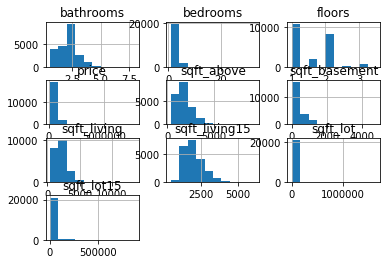

In [27]:
df_num.hist()

In [28]:
df_num['sqft_living_log'] = np.log(df_num['sqft_living'])
df_num['sqft_above_log'] = np.log(df_num['sqft_above'])
df_num['sqft_lot_log'] = np.log(df_num['sqft_lot'])
df_num['sqft_basement_log'] = np.log(df_num['sqft_basement'])
df_num['sqft_living15_log'] = np.log(df_num['sqft_living15'])
df_num['sqft_lot15_log'] = np.log(df_num['sqft_lot15'])
df_num['bathrooms'] = np.log(df_num['bathrooms'])
df_num['bedrooms'] = np.log(df_num['bedrooms'])
df_num['floors'] = np.log(df_num['floors'])

In [30]:
df_num.describe()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_basement_log,sqft_living15_log,sqft_lot15_log
count,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000
mean,5.407393e+05,1.178157,0.679045,0.339718,2083.132633,1.512804e+04,1791.170215,285.904342,1988.384080,12775.718161,7.552148,7.396578,8.989676,-inf,7.540403,8.960509
std,3.679311e+05,0.282686,0.392025,0.352451,918.808412,4.153080e+04,828.692965,440.008202,685.537057,27345.621867,0.424047,0.427241,0.903854,NaN,0.327440,0.814079
min,7.800000e+04,0.000000,-0.693147,0.000000,370.000000,5.200000e+02,370.000000,0.000000,399.000000,651.000000,5.913503,5.913503,6.253829,-inf,5.988961,6.478510
25%,3.225000e+05,1.098612,0.559616,0.000000,1430.000000,5.040000e+03,1200.000000,0.000000,1490.000000,5100.000000,7.265430,7.090077,8.525161,-inf,7.306531,8.536996
50%,4.500000e+05,1.098612,0.810930,0.405465,1920.000000,7.614000e+03,1560.000000,0.000000,1840.000000,7620.000000,7.560080,7.352441,8.937744,-inf,7.517521,8.938532
75%,6.450000e+05,1.386294,0.916291,0.693147,2550.000000,1.069050e+04,2220.000000,550.000000,2370.000000,10086.250000,7.843849,7.705262,9.277111,6.309918e+00,7.770645,9.218928
max,7.700000e+06,3.496508,2.079442,1.252763,13540.000000,1.651359e+06,9410.000000,4820.000000,6210.000000,871200.000000,9.513404,9.149528,14.317109,8.480529e+00,8.733916,13.677627


In [31]:
df_combo = pd.concat([df_num, df_cat], axis=1)
df_combo.head()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,...,sqft_lot_log,sqft_basement_log,sqft_living15_log,sqft_lot15_log,view,condition,waterfront,grade,yr_built,yr_renovated
0,221900.0,1.098612,0.000000,0.000000,1180,5650,1180,0.0,1340,5650,...,8.639411,-inf,7.200425,8.639411,0.0,3,0.0,7,1955,0.0
1,538000.0,1.098612,0.810930,0.693147,2570,7242,2170,400.0,1690,7639,...,8.887653,5.991465,7.432484,8.941022,0.0,3,0.0,7,1951,1991.0
2,180000.0,0.693147,0.000000,0.000000,770,10000,770,0.0,2720,8062,...,9.210340,-inf,7.908387,8.994917,0.0,3,0.0,6,1933,1933.0
3,604000.0,1.386294,1.098612,0.000000,1960,5000,1050,910.0,1360,5000,...,8.517193,6.813445,7.215240,8.517193,0.0,5,0.0,7,1965,0.0
4,510000.0,1.098612,0.693147,0.000000,1680,8080,1680,0.0,1800,7503,...,8.997147,-inf,7.495542,8.923058,0.0,3,0.0,8,1987,0.0


In [73]:
df_num_to_ols = pd.DataFrame.drop(df_num, columns=['sqft_lot'], inplace=True)

In [74]:
df_num_to_ols = pd.DataFrame.drop(df_num, columns=['sqft_basement_log'])

In [75]:
df_num_to_ols.head()

,price,bedrooms,bathrooms,floors,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_living15_log,sqft_lot15_log
0,221900.0,1.098612,0.000000,0.000000,7.073270,7.073270,8.639411,7.200425,8.639411
1,538000.0,1.098612,0.810930,0.693147,7.851661,7.682482,8.887653,7.432484,8.941022
2,180000.0,0.693147,0.000000,0.000000,6.646391,6.646391,9.210340,7.908387,8.994917
3,604000.0,1.386294,1.098612,0.000000,7.580700,6.956545,8.517193,7.215240,8.517193
4,510000.0,1.098612,0.693147,0.000000,7.426549,7.426549,8.997147,7.495542,8.923058


In [102]:
df_combo = pd.concat([df_num_to_ols, df_cat], axis=1)
df_combo.dtypes

price                float64
bedrooms             float64
bathrooms            float64
floors               float64
sqft_living_log      float64
sqft_above_log       float64
sqft_lot_log         float64
sqft_living15_log    float64
sqft_lot15_log       float64
view                 float64
condition              int64
waterfront           float64
grade                  int64
yr_built               int64
yr_renovated         float64
dtype: object

In [108]:
outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'floors', 'sqft_living_log',
       'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log', 'sqft_lot15_log',
       'view', 'condition', 'waterfront', 'grade', 'yr_built', 'yr_renovated']

In [110]:
# Some brief preprocessing
df_combo.columns = [col.replace(' ', '_') for col in df_combo.columns]
for col in x_cols:
   df_combo[col] = (df_combo[col] - df_combo[col].mean())/df_combo[col].std()
df_combo.head()

,price,bedrooms,bathrooms,floors,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_living15_log,sqft_lot15_log,view,condition,waterfront,grade,yr_built,yr_renovated
0,221900.0,-0.281389,-1.732147,-0.963873,-1.129304,-0.756736,-0.387524,-1.038290,-0.394431,-0.305691,-0.631942,-0.08284,-0.565536,-0.547620,-0.518817
1,538000.0,-0.281389,0.336421,1.002778,0.706321,0.669188,-0.112876,-0.329584,-0.023937,-0.305691,-0.631942,-0.08284,-0.565536,-0.683734,1.946970
2,180000.0,-1.715721,-1.732147,-0.963873,-2.135982,-1.755890,0.244137,1.123821,0.042266,-0.305691,-0.631942,-0.08284,-1.418799,-1.296247,1.875139
3,604000.0,0.736285,1.070257,-0.963873,0.067332,-1.029941,-0.522743,-0.993045,-0.544561,-0.305691,2.444815,-0.08284,-0.565536,-0.207335,-0.518817
4,510000.0,-0.281389,0.035973,-0.963873,-0.296190,0.070150,0.008266,-0.137005,-0.046004,-0.305691,-0.631942,-0.08284,0.287727,0.541291,-0.518817


In [113]:
    # Fitting the actual model
    predictors = '+'.join(x_cols)
    formula = outcome + '~' + predictors
    model = ols(formula=formula, data=df_combo).fit()
    model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     2394.
Date:                Thu, 13 Feb 2020   Prob (F-statistic):               0.00
Time:                        12:38:00   Log-Likelihood:            -2.9481e+05
No. Observations:               21420   AIC:                         5.897e+05
Df Residuals:                   21405   BIC:                         5.898e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.407e+05   1569.985    344.423      0.000    5.38e+05    5.44e+05
bedrooms          -2.365e+04   2146.639    -11.015      0.000   -2.79e+04   -1.94e+04
bathrooms          2.365e+04   2876.207      8.224      0.000     1.8e+04    2.93e+04
floors              887.5192   2452.241      0.362      0.717   -3919.056    5694.094
sqft_living_log     7.76e+04   4464.562     17.382      0.000    6.89e+04    8.64e+04
sqft_above_log       1.7e+04   4112.473      4.134      0.000    8940.443    2.51e+04
sqft_lot_log      -5122.4898   4112.191     -1.246      0.213   -1.32e+04    2937.711
sqft_living15_log  2.635e+04   2610.216     10.094      0.000    2.12e+04    3.15e+04
sqft_lot15_log    -2.087e+04   4041.009     -5.165      0.000   -2.88e+04   -1.29e+04
view               4.247e+04   1814.573     23.404      0.000    3.89e+04     4.6e+04
condition          1.415e+04   1729.338      8.181      0.000    1.08e+04    1.75e+04
waterfront         5.398e+04   1704.652     31.667      0.000    5.06e+04    5.73e+04
grade              1.909e+05   2708.603     70.476      0.000    1.86e+05    1.96e+05
yr_built           -1.08e+05   2156.134    -50.096      0.000   -1.12e+05   -1.04e+05
yr_renovated       3883.5563   1586.938      2.447      0.014     773.039    6994.074
==============================================================================
Omnibus:                    19957.562   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2804094.351
Skew:                           4.050   Prob(JB):                         0.00
Kurtosis:                      58.464   Cond. No.                         8.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
#dropping floors and sqft_lot_log

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living_log',
       'sqft_above_log',  'sqft_living15_log', 'sqft_lot15_log',
       'view', 'condition', 'waterfront', 'grade', 'yr_built', 'yr_renovated']

In [115]:
# Some brief preprocessing
df_combo.columns = [col.replace(' ', '_') for col in df_combo.columns]
for col in x_cols:
   df_combo[col] = (df_combo[col] - df_combo[col].mean())/df_combo[col].std()
df_combo.head()

,price,bedrooms,bathrooms,floors,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_living15_log,sqft_lot15_log,view,condition,waterfront,grade,yr_built,yr_renovated
0,221900.0,-0.281389,-1.732147,-0.963873,-1.129304,-0.756736,-0.387524,-1.038290,-0.394431,-0.305691,-0.631942,-0.08284,-0.565536,-0.547620,-0.518817
1,538000.0,-0.281389,0.336421,1.002778,0.706321,0.669188,-0.112876,-0.329584,-0.023937,-0.305691,-0.631942,-0.08284,-0.565536,-0.683734,1.946970
2,180000.0,-1.715721,-1.732147,-0.963873,-2.135982,-1.755890,0.244137,1.123821,0.042266,-0.305691,-0.631942,-0.08284,-1.418799,-1.296247,1.875139
3,604000.0,0.736285,1.070257,-0.963873,0.067332,-1.029941,-0.522743,-0.993045,-0.544561,-0.305691,2.444815,-0.08284,-0.565536,-0.207335,-0.518817
4,510000.0,-0.281389,0.035973,-0.963873,-0.296190,0.070150,0.008266,-0.137005,-0.046004,-0.305691,-0.631942,-0.08284,0.287727,0.541291,-0.518817


In [116]:
    # Fitting the actual model
    predictors = '+'.join(x_cols)
    formula = outcome + '~' + predictors
    model = ols(formula=formula, data=df_combo).fit()
    model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     2793.
Date:                Thu, 13 Feb 2020   Prob (F-statistic):               0.00
Time:                        13:04:40   Log-Likelihood:            -2.9481e+05
No. Observations:               21420   AIC:                         5.897e+05
Df Residuals:                   21407   BIC:                         5.898e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.407e+05   1569.980    344.424      0.000    5.38e+05    5.44e+05
bedrooms           -2.37e+04   2141.523    -11.069      0.000   -2.79e+04   -1.95e+04
bathrooms          2.407e+04   2808.034      8.573      0.000    1.86e+04    2.96e+04
sqft_living_log    7.676e+04   4318.595     17.773      0.000    6.83e+04    8.52e+04
sqft_above_log     1.746e+04   3482.362      5.015      0.000    1.06e+04    2.43e+04
sqft_living15_log  2.638e+04   2603.227     10.135      0.000    2.13e+04    3.15e+04
sqft_lot15_log    -2.573e+04   1778.436    -14.466      0.000   -2.92e+04   -2.22e+04
view               4.244e+04   1814.317     23.393      0.000    3.89e+04     4.6e+04
condition          1.415e+04   1722.232      8.218      0.000    1.08e+04    1.75e+04
waterfront         5.404e+04   1703.802     31.716      0.000    5.07e+04    5.74e+04
grade              1.911e+05   2700.039     70.792      0.000    1.86e+05    1.96e+05
yr_built          -1.077e+05   2139.388    -50.346      0.000   -1.12e+05   -1.04e+05
yr_renovated       3908.3162   1586.827      2.463      0.014     798.016    7018.616
==============================================================================
Omnibus:                    19943.482   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2796233.979
Skew:                           4.046   Prob(JB):                         0.00
Kurtosis:                      58.385   Cond. No.                         7.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Regression model Validation

In [121]:
#dropping floors and sqft_lot_log

y = pd.DataFrame(df_combo, columns=['price'])

X = df_combo[['bedrooms', 'bathrooms', 'sqft_living_log',
       'sqft_above_log',  'sqft_living15_log', 'sqft_lot15_log',
       'view', 'condition', 'waterfront', 'grade', 'yr_built', 'yr_renovated']]

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [124]:
# A brief preview of our train test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

16065 5355 16065 5355


In [125]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [128]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [129]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [130]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [131]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [132]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [134]:
from sklearn.metrics import mean_squared_error

In [135]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 54259272470.88707
Test Mean Squarred Error: 48368374194.17502


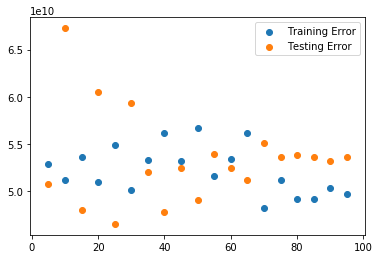

In [136]:
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

In [137]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

In [ ]:
#Cross-Validation

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [140]:
# A brief preview of train-test split
print(len(X_train), len(X_test), len(y_train), len(y_test))


17136 4284 17136 4284


In [141]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

In [142]:
test_residuals = y_hat_test - y_test

test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

58528688426.69177

In [144]:
def kfolds(data, k):
    # Force data as pandas DataFrame
    data = pd.DataFrame(df_combo)
    num_observations = len(df_combo)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  df_combo.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  df_combo.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size
            
    return folds 

In [145]:
combo_data = pd.concat([X.reset_index(drop=True), y], axis=1)

In [146]:
combo_folds = kfolds(combo_data, 5)

In [149]:
test_errs = []
train_errs = []
k=5

for n in range(k):
    # Split in train and test for the fold
    train = pd.concat([fold for i, fold in enumerate(combo_folds) if i!=n])
    test = combo_folds[n]
    # Fit a linear regression model
    linreg.fit(train[X.columns], train[y.columns])
    #Evaluate Train and Test Errors
    y_hat_train = linreg.predict(train[X.columns])
    y_hat_test = linreg.predict(test[X.columns])
    train_residuals = y_hat_train - train[y.columns]
    test_residuals = y_hat_test - test[y.columns]
    train_errs.append(np.mean(train_residuals.astype(float)**2))
    test_errs.append(np.mean(test_residuals.astype(float)**2))
print(train_errs)
print(test_errs)

[price    5.107558e+10
dtype: float64, price    5.181307e+10
dtype: float64, price    5.424170e+10
dtype: float64, price    5.428481e+10
dtype: float64, price    5.207866e+10
dtype: float64]
[price    5.993978e+10
dtype: float64, price    5.664709e+10
dtype: float64, price    4.697399e+10
dtype: float64, price    4.692884e+10
dtype: float64, price    5.650161e+10
dtype: float64]


In [150]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_squared_error')

In [151]:
cv_5_results

array([-5.99397808e+10, -5.66470917e+10, -4.69739915e+10, -4.69288374e+10,
       -5.65016143e+10])